In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [6]:
from collections import Counter

In [4]:
def allocate_singlehop(N, weights):
    """ 
    allocate N circuits of length 1 proportional to the relay weights specified.
    returns an array of relays selected for each circuit 
    """
    return np.random.choice(range(len(weights)), N, replace=True, p=weights)

In [5]:
allocate_singlehop(10, [1/2,1/2])

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0])

In [7]:
def measure(circuits, capacities):
    """
    Simulate running a measurement of each relay given a set of allocated circuits.
    
    Returns an array of the bandwidth allocated to each measurement (one-hop) circuit,
    assuming relay capacity is split evenly among existing and measurement circuits. 
    """
    # compute the histogram of number of circuits on each relay
    hist = Counter(circuits)
    return [ c / (hist[i] + 1) for i,c in enumerate(capacities) ]

In [8]:
circuits = allocate_singlehop(10, [0.5,0.5])
capacities = [10, 20]
m = measure(circuits, capacities)
circuits, m

(array([1, 0, 1, 0, 1, 0, 0, 1, 0, 0]), [1.4285714285714286, 4.0])

In [9]:
def loss(measurements):
    """
    Given a set of measurements, compute the deviation from the average for each measurements
    """
    avg = sum(measurements) / len(measurements)
    return [ (m - avg) / avg for m in measurements ]

In [10]:
loss(m)

[-0.4736842105263158, 0.4736842105263157]

In [66]:
def simulate(num_circuits, capacities, K_p, K_i, K_d, num_steps = 1000, w0 = None):
    """
    Yields a sequence of weights while simulating a PID controller with the given parameters
    """
    if w0 is None:
        weights = np.ones(len(capacities)) / len(capacities)
    else:
        weights = np.array(w0)
    prev_loss = None
    integral = np.zeros(len(capacities))
    for _ in range(num_steps):
        yield list(weights)
        circuits = allocate_singlehop(num_circuits, weights)
        measurements = measure(circuits, capacities)
        cur_loss = np.array(loss(measurements))
        integral += cur_loss
        if prev_loss is not None:
            derivative = cur_loss - prev_loss
        else:
            derivative = np.zeros(len(capacities))
        weights += K_p*cur_loss + K_i * integral + K_d*derivative
        # remove negative weights and renormalize
        weights = np.fmax(weights, np.zeros(len(capacities)))
        weights /= sum(weights)
        prev_loss = cur_loss
        

In [71]:
# I think these were the parameters used in a previous version of TorFlow
result = np.array(list(simulate(4, [1/3, 2/3], 1.0, 1/5, 1/2, 1000)))

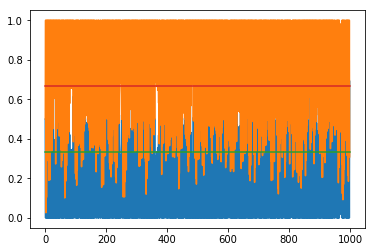

In [76]:
plt.plot(result[:,0])
plt.plot(result[:,1])
plt.plot([1/3 for _ in range(1000)])
plt.plot([2/3 for _ in range(1000)])

In [73]:
result_ponly = np.array(list(simulate(4, [1/3, 2/3], 0.25, 0, 0, 1000)))

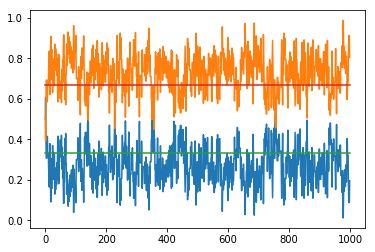

In [75]:
plt.plot(result_ponly[:,0])
plt.plot(result_ponly[:,1])
plt.plot([1/3 for _ in range(1000)])
plt.plot([2/3 for _ in range(1000)])